---
### *The Tenth Computational Neuroscience Winter School*
# Tutorial I: Network Dynamics : Spectrum of Lyapunov exponents of I&F type dynamical system
---
__Date:__ Jan. 13, 2021

__Content Creator:__ Kai Chen

**Reference:** *Zhou, D., Sun, Y., Rangan, A. V., & Cai, D. (2010). Spectrum of lyapunov exponents of non-smooth dynamical systems of integrate-and-fire type. Journal of Computational Neuroscience, 28(2), 229-245.*

# Tutorial Objectives

In this tutorial, we will go through a common tool for analyzing the stability of dynamical systems, called Lyapunov exponents. 

1. Understand the definition of Lyapunov exponents(LEs) for smooth dynamical system, and how to numerically calculate it.
1. How to extend the definition to non-smooth dynamical system, especially for Conductance-based LIF neuron and networks.
1. Numerically estimate the spectrum of LEs for Conductance based LIF neuronal networks.

# Setup

In [112]:
# @title Import most modules and functions needed
import time
import numpy as np 
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from brian2 import *

# Build Linear LIF network

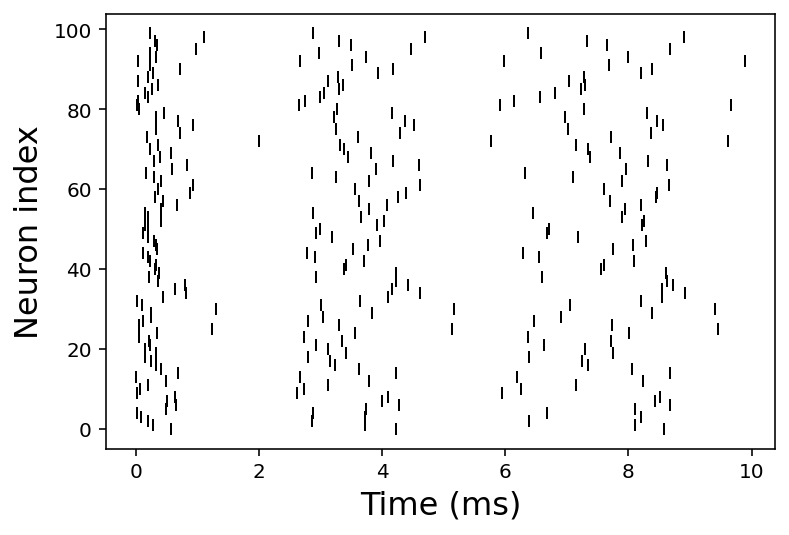

In [25]:
start_scope()

defaultclock.dt = 0.01*ms
# Parameters
gl = 0.05 / ms

tau_e = 2*ms
V_thred = 1.
V_rest = 0.
E_l = 0.
E_e = 14.0/3.0
E_i = -80*mV
I0 = 0.05/ms
I1 = 0.05/ms
mu = 0.04/ms

eqs = '''
dv/dt = gl * (E_l - v) + g * (E_e - v) + I0 + I1*cos(2*pi*mu*t+phi) : 1 (unless refractory)
dg/dt = -g/tau_e : second**-1
phi : 1
'''

N = 100
G = NeuronGroup(N, eqs, threshold='v>V_thred', reset='v=V_rest', refractory=2*ms, method='euler')
G.phi = '2*pi*(i-1)/N'

w = 2e-3/ms  # excitatory synaptic weight
S = Synapses(G,G, on_pre='g += w')
S.connect()

# initialization
seed(20210113)
G.v = 'rand()'
G.g = 'rand()/ms'

state_monitor = StateMonitor(G, ['v','g'], record=True)
spike_monitor = SpikeMonitor(G)

net = Network(G, S, state_monitor, spike_monitor)

net.run(10*ms)

plot(spike_monitor.t/ms, spike_monitor.i, '|k')
xlabel('Time (ms)')
ylabel('Neuron index');

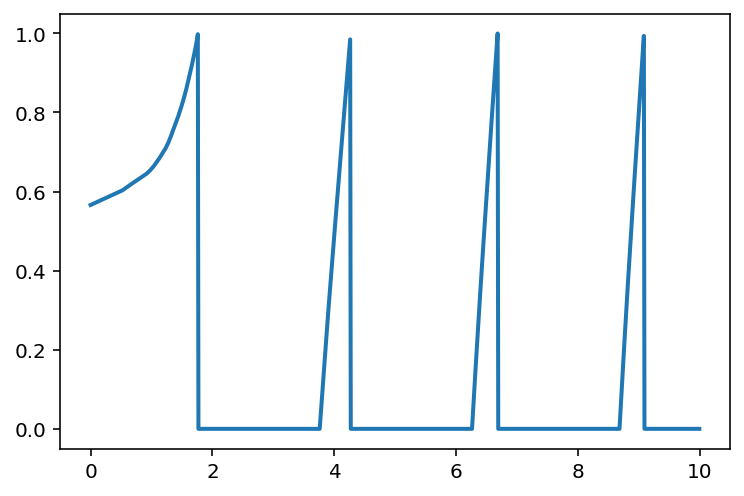

In [14]:
plot(state_monitor.t/ms, state_monitor.v[0])

In [33]:
G.v*1, G.g*ms

(array([0.        , 0.        , 0.80308704, 0.        , 0.63465427,
        0.        , 0.        , 0.        , 0.        , 0.98249936,
        0.83783562, 0.37576889, 0.        , 0.86430894, 0.        ,
        0.        , 0.28745509, 0.33471142, 0.7874843 , 0.10408648,
        0.31128852, 0.66723325, 0.12243281, 0.79988156, 0.        ,
        0.        , 0.11526048, 0.76565908, 0.52603942, 0.        ,
        0.        , 0.45171257, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.73631406, 0.        ,
        0.21107372, 0.18754074, 0.        , 0.78237344, 0.92369837,
        0.12091536, 0.        , 0.        , 0.42252155, 0.72071701,
        0.70854901, 0.        , 0.        , 0.05397722, 0.87002605,
        0.02459104, 0.        , 0.15244892, 0.        , 0.        ,
        0.1999557 , 0.        , 0.05476659, 0.4840148 , 0.9563742 ,
        0.01973858, 0.        , 0.        , 0.32248381, 0.06416201,
        0.34041103, 0.45503994, 0.        , 0.13

In [45]:
pm = {'tau_e'   : 2.,
      'V_thred' : 1.,
      'V_rest'  : 0.,
      'gl'      : 0.05,
      'E_l'     : 0.,
      'E_e'     : 14.0/3.0,
      'I0'      : 0.05,
      'I1'      : 0.05,
      'mu'      : 0.04,
      't_ref'   : 2.
     }

In [124]:
# euler updater
def euler(pm, f, v, g, phi, t, dt):
    dvdt, dgdt = f(pm, v, g, phi, t)
    return v + dt * dvdt, g + dt * dgdt

def f(pm, v, g, phi, t):
    dv = pm['gl'] * (pm['E_l'] - v) + g * (pm['E_e'] - v) + pm['I0'] + pm['I1']*np.cos(2*np.pi*pm['mu']*t+phi)
    dg = -g / pm['tau_e']
    return dv, dg

def is_fire(pm, v, g, t_ref)->np.ndarray:
    '''
    Whether neuron is fire or not
    '''
    mask = v>pm['V_thred']
    t_ref[mask]=pm['t_ref']
    v[mask] = pm['V_rest']
    return np.where(mask)[0]
                
def evolve_LIF(pm, v0, g0, t_ref0, T, dt):
    spike_train = np.array([[0,0]])
    t = np.arange(0, T, dt)
    v = v0.copy()
    g = g0.copy()
    N = len(v)
    phi = np.array([2*np.pi*(i-1)/N for i in range(N)])
    t_ref = t_ref0.copy()
    for idx, t in enumerate(t):
        # independent evolution of neuronal dynamics
        update_mask = (t_ref<=0)  # masking neurons are out of refractory period
        v[update_mask], g[update_mask] = euler(pm, f, v[update_mask], g[update_mask], phi[update_mask], t, dt)
        t_ref -= t_ref               # Update refractory residence state
        new_spike_id = is_fire(pm, v,g,t_ref)
        if len(new_spike_id) > 0:
            spike_train = np.append(spike_train, np.array([[idx, t + dt] for idx in new_spike_id]),axis=0)
        # fully connected recurrent interactions
        g += len(new_spike_id) * 1e-3
    spike_train = spike_train[1:,:]
    return spike_train, v, g, t_ref
    

In [125]:
N = 100
np.random.seed(2021)
v0 = np.random.rand(N)
g0 = np.zeros(N)
t_ref0 = np.zeros(N)
T = 100
dt = 0.01
spk_trains, v, g, t_ref = evolve_LIF(pm, v0, g0, t_ref0, T, dt)

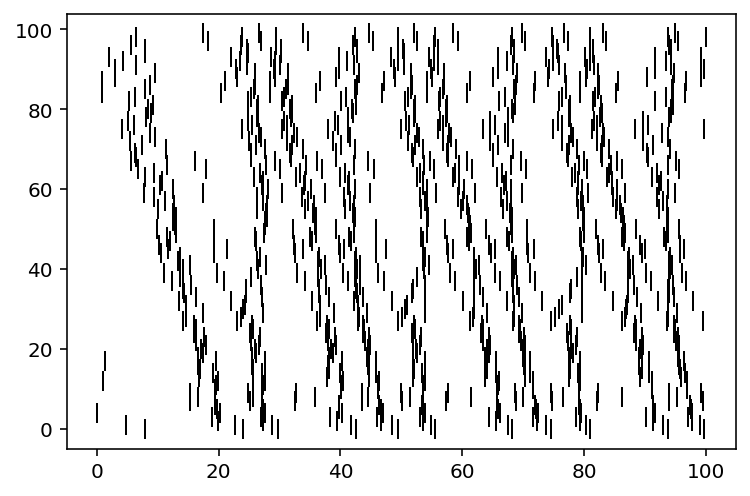

In [127]:
plt.plot(spk_trains[:,1], spk_trains[:,0], '|k', ms=10)

In [132]:
def GSR(X):
    '''Gram-Schmit Reorthognormalization.
        Inplace GSR operation towards matrix X.
        
    Args:
    Original Matrix X
    
    Return:
    Othorognormal matrix X_normal
    '''
    X_normal = np.zeros_like(X)
    X_normal[:, 0] = X[:,0]/np.sqrt(X[:,0]@X[:,0])
    for i in range(1, X.shape[1]):
        for j in range(i):
            X[:,i] -= X[:,i]@X_normal[:,j] * X_normal[:,j]
        # normalization
        X_normal[:, i] = X[:,i]/np.sqrt(X[:,i]@X[:,i])
    return X_normal
        
    
def LyapunovExponents(f, x0, dT, epsilon, tol):
    Lambda = np.zeros_like(x0)
    perturb_space = np.eye(len(x0))
    while True:
        for i in range(perturb_space.shape[1]):
            X
            _,new_v,new_g,new_t_ref = evolve_LIF(pm, v0, g0, t_ref0, T, dt)    
        
        if np.max(np.abs(dLambda)) < tol:
            break
    
    return Lambda

In [133]:
X = np.random.rand(3,3)
print(X)

[[0.1482483  0.39368226 0.80261811]
 [0.81018863 0.7960028  0.85798945]
 [0.29674024 0.15884363 0.68614311]]


In [134]:
X_normal = GSR(X)
print(X_normal)
print(X)

[[ 0.16933675  0.88357722  0.43659633]
 [ 0.92543868  0.00980006 -0.37877067]
 [ 0.3389518  -0.46818292  0.81603702]]
[[ 0.1482483   0.24853408  0.25556475]
 [ 0.81018863  0.00275658 -0.22171609]
 [ 0.29674024 -0.13169128  0.47767304]]
